In [1]:
from traci_backend import TraciBackend
import random
import matplotlib.pyplot as plt

In [5]:
class Agent():
    def __init__(self, discount, alpha, epsilon):
        self.tb = TraciBackend()
        self.discount = discount
        self.alpha = alpha
        self.epsilon = epsilon
        self.weights1 = [1] * 4 # for action1
        self.weights2 = [1] * 4 # for action2
        
    def getStateRewardCum(self, edges, num_iter):
        '''
        Fetch data from traci backend,
        return the state and reward
        The reward is calculated using data from accumulative step.
        '''
        tb = self.tb
        reward = 0
#         isEnd = True
        evaluation = 0
        for _ in range(num_iter):
#             if isEnd:
#                 break
#             isEnd = True
            tb.simulate_step()
            evaluation += self.getEvaluationUnit()
            state = [0] * 4
            for n, edge in enumerate(edges):
                line_length, total_vehicle_num = \
                    tb.get_halt_vehicle_cnt_edge(edge), tb.get_vehicle_cnt_edge(edge)
                pass_vehicle_num = total_vehicle_num - line_length
    #             pass_vehicle_num = total_vehicle_num
                if n < 2:
                    state[0] += line_length
                    state[1] += pass_vehicle_num
                else:
                    state[2] += line_length
                    state[3] += pass_vehicle_num
                reward += pass_vehicle_num - line_length
#         print(state, reward)
        return state, reward, tb.is_end(), evaluation
        
    def getStateReward(self, edges):
        '''
        Fetch data from traci backend,
        return the state and reward of this step
        The reward is calculated using data from a specific step,
        not accumulated.
        '''
        tb = self.tb
        state, reward = [0] * 4, 0
        for n, edge in enumerate(edges):
            line_length, total_vehicle_num = tb.get_halt_vehicle_cnt_edge(edge), tb.get_vehicle_cnt_edge(edge)
            
            pass_vehicle_num = total_vehicle_num - line_length
#             pass_vehicle_num = total_vehicle_num
            if n < 2:
                state[0] += line_length
                state[1] += pass_vehicle_num
            else:
                state[2] += line_length
                state[3] += pass_vehicle_num
            reward += pass_vehicle_num - line_length
#         print(state, reward)
        return state, reward, tb.is_end()
#         state = [time()] # add time stamp in SUMO
#         lengths = getAllQueueLength()
#         state += lengths # add four elements
#         passes = getLastStepPass()
#         state += passes # add four elements
#         return state, sum([passes[i] - lengths[i] for i in range(4)])
    
    def getQ(self, state):
        '''
        Use the function approximator, give out the approximated value
        '''
#         tb = self.tb
        q1, q2 = 0, 0
        for i in range(4):
            q1 += state[i] * self.weights1[i]
            q2 += state[i] * self.weights2[i]
        return q1, q2
        
    def eGreedy(self, q):
        '''
        Return the action selection 0 or 1 according to q-value
        '''
#         tb = self.tb
        q1, q2 = q[0], q[1]
#         print("The approximated q values =", q1, q2)
        rand = random.random()
        if q1 == q2:
            return 0 if rand < 0.5 else 1
        if rand < self.epsilon and q1 < q2 or rand > self.epsilon and q1 > q2:
#             print("We choose action1")
            return 0
        else:
#             print("We choose action2")
            return 1
        
        
    def updateWeight(self, curr_state, next_state, reward, action):
        '''
        Use approximate Q-learning, update weight in the approximator
        '''
#         print("Update weights with current state", curr_state, "next state", next_state, "and reward", reward)
        q_curr = self.getQ(curr_state)[action] # current approximated q value
        q_next_act = self.getQ(next_state) # next approximated q value for both action
        next_act = self.eGreedy(q_next_act) # get the action by epsilon greedy
#         print("Epsilon greedy chooses the action", next_act + 1)
#         q_next = q_next_act[next_act]
        q_next = max(q_next_act)
        delta = reward + self.discount * q_next - q_curr
#         print("delta =", delta, "q_curr", q_curr, "q_next", q_next)
        # only update one weights array, either for action1 or action2
        if action:
            self.weights2 = [self.weights2[i] + self.alpha * delta * curr_state[i] for i in range(4)]
        else:
            self.weights1 = [self.weights1[i] + self.alpha * delta * curr_state[i] for i in range(4)]
#         print(self.weights1, self.weights2)
        return next_act, action ^ next_act
    
    def executeAction(self, action, change):
        '''
        Adjust the lights in sumo given the action 0 or 1
        '''
        tb = self.tb
        evaluation = 0
        if not change and action:
            tb.set_light_phase('0', 4)
            return evaluation
        elif not change and not action:
            tb.set_light_phase('0', 0)
            return evaluation
        elif change and action:
            tb.set_light_phase('0', 1)
            for _ in range(3):
                tb.simulate_step()
                evaluation += self.getEvaluationUnit()
            tb.set_light_phase('0', 2)
            for _ in range(5):
                tb.simulate_step()
                evaluation += self.getEvaluationUnit()
            tb.set_light_phase('0', 3)
            for _ in range(3):
                tb.simulate_step()
                evaluation += self.getEvaluationUnit()
            tb.set_light_phase('0', 4)
        else:
            tb.set_light_phase('0', 5)
            for _ in range(3):
                tb.simulate_step()
                evaluation += self.getEvaluationUnit()
            tb.set_light_phase('0', 6)
            for _ in range(5):
                tb.simulate_step()
                evaluation += self.getEvaluationUnit()
            tb.set_light_phase('0', 7)
            for _ in range(3):
                tb.simulate_step()
                evaluation += self.getEvaluationUnit()
            tb.set_light_phase('0', 0)
        return evaluation
        
    def getEvaluationUnit(self):
        tb = self.tb
        evaluation = 0
        for edge in ['1si', '2si', '3si', '4si']:
            evaluation += tb.get_halt_vehicle_cnt_edge(edge)
        return evaluation
    
    def train(self, step_size):
        '''
        Train the agent with num_iter, observe the reward from traci backend every step_size period.
        step_size is the time before observing the state and reward, should be smaller than 31.
        '''
#         tb = TraciBackend()
        tb = self.tb
        tb.start()
        prev_state = [0] * 4
        next_act, change = 0, True
        weights_history = [[], []]
        isEnd = False
        evaluation = 0
        while not isEnd:
#             state, reward = [0], 0
            evaluation += self.executeAction(next_act, change)
            for _ in range(step_size):
                tb.simulate_step()
                evaluation += self.getEvaluationUnit()
#             lanes = tb.get_lane_ids()
#             lights = tb.get_light_ids()
            state, reward, isEnd = self.getStateReward(['1si', '2si', '3si', '4si'])
            weights_history[0].append(self.weights1)
            weights_history[1].append(self.weights2)
            next_act, change = self.updateWeight(prev_state, state, reward, next_act)
            
#             for lane in lanes:
#                 line_length = tb.get_halt_vehicle_cnt(lane)
#                 total_vehicle_num = tb.get_vehicle_cnt(lane)
#                 pass_vehicle_num = total_vehicle_num - line_length
#                 state += [line_length, pass_vehicle_num]
#                 reward += pass_vehicle_num - line_length
            prev_state = state
            
#         print(weights_history)
        tb.close()
        return weights_history, evaluation
    
    def train2(self, step_size):
        '''
        Train the agent with num_iter, observe the reward from traci backend every step_size period.
        step_size is the time before observing the state and reward
        '''
#         tb = TraciBackend()
        tb = self.tb
        tb.start()
        prev_state = [0] * 4
        next_act, change = 0, True
        weights_history = [[], []]
        isEnd = False
        evaluation = 0
        while not isEnd:
#             state, reward = [0], 0
            evaluation += self.executeAction(next_act, change)
                
            state, reward, isEnd, evaluationUnit = self.getStateRewardCum(['1si', '2si', '3si', '4si'], step_size)
            weights_history[0].append(self.weights1)
            weights_history[1].append(self.weights2)
            evaluation += evaluationUnit
            next_act, change = self.updateWeight(prev_state, state, reward, next_act)
            
#             for lane in lanes:
#                 line_length = tb.get_halt_vehicle_cnt(lane)
#                 total_vehicle_num = tb.get_vehicle_cnt(lane)
#                 pass_vehicle_num = total_vehicle_num - line_length
#                 state += [line_length, pass_vehicle_num]
#                 reward += pass_vehicle_num - line_length
            prev_state = state
            
#         print(weights_history)
        tb.close()
        return weights_history, evaluation
    
        

class StaticAgent:
    
    def __init__(self):
        self.tb = TraciBackend()
    def train(self):
        evaluation, step = 0, 0
        tb = self.tb
        tb.start()
        while not tb.is_end():
#         for _ in range(1000):
            tb.simulate_step()
            step += 1
#             print(tb.get_cur_light_state('0'))
            for edge in ['1si', '2si', '3si', '4si']:
                evaluation += tb.get_halt_vehicle_cnt_edge(edge)
#                 total_vehicle_num += tb.get_vehicle_cnt_edge(edge)
        tb.close()
        print(step)
        return evaluation
            

class LongestQueueFirstAgent:
    
    def __init__(self):
        self.tb = TraciBackend()
    
    def getEvaluationUnit(self):
        tb = self.tb
        evaluation = 0
        for edge in ['1si', '2si', '3si', '4si']:
            evaluation += tb.get_halt_vehicle_cnt_edge(edge)
        return evaluation
    
    def executeAction(self, action, change):
        '''
        Adjust the lights in sumo given the action 0 or 1
        '''
        tb = self.tb
        evaluation = 0
        if not change and action:
            tb.set_light_phase('0', 4)
            return evaluation
        elif not change and not action:
            tb.set_light_phase('0', 0)
            return evaluation
        elif change and action:
            tb.set_light_phase('0', 1)
            for _ in range(3):
                tb.simulate_step()
                evaluation += self.getEvaluationUnit()
            tb.set_light_phase('0', 2)
            for _ in range(5):
                tb.simulate_step()
                evaluation += self.getEvaluationUnit()
            tb.set_light_phase('0', 3)
            for _ in range(3):
                tb.simulate_step()
                evaluation += self.getEvaluationUnit()
            tb.set_light_phase('0', 4)
        else:
            tb.set_light_phase('0', 5)
            for _ in range(3):
                tb.simulate_step()
                evaluation += self.getEvaluationUnit()
            tb.set_light_phase('0', 6)
            for _ in range(5):
                tb.simulate_step()
                evaluation += self.getEvaluationUnit()
            tb.set_light_phase('0', 7)
            for _ in range(3):
                tb.simulate_step()
                evaluation += self.getEvaluationUnit()
            tb.set_light_phase('0', 0)
        return evaluation
    
    def train(self, step_size):
        evaluation, isEnd, action, change, step = 0, False, 0, False, 0
#         tb = TraciBackend()
        tb = self.tb
        tb.start()
        while not tb.is_end():
            step += 1
            evaluation += self.executeAction(action, change)
            for i in range(step_size): 
                tb.simulate_step()
                total_vehicle_num, halting_nums = 0, [0, 0]
                for edge in ['1si', '2si', '3si', '4si']:
                    halting_nums[edge == '3si' or edge == '4si'] += tb.get_halt_vehicle_cnt_edge(edge)
                    total_vehicle_num += tb.get_vehicle_cnt_edge(edge)
#                     print(total_vehicle_num, halting_nums)
                evaluation += sum(halting_nums)
            next_act = 1 if halting_nums[0] > halting_nums[1] else 0
            change = action ^ next_act
            action = next_act
#             print(action, halting_nums)
        tb.close()
        print(step)
        return evaluation

In [10]:
data0_8_agent = evaluation

In [11]:
def test_Agent1(gamma, alpha, e):   
    simulateAgent = Agent(gamma, alpha, e)
    evaluation = []
    for _ in range(100):
        _, evaluateUnit = simulateAgent.train(20)
        evaluation.append(evaluateUnit)
    return evaluation
#     print(simulateAgent.weights1, simulateAgent.weights2)

def test_Agent2(gamma, alpha, e):
    simulateAgent = Agent(gamma, alpha, e)
    evaluation = []
    for _ in range(100):
        _, evaluateUnit = simulateAgent.train2(20)
        evaluation.append(evaluateUnit)
#         print(simulateAgent.weights1, simulateAgent.weights2)
    return evaluation

def test_StaticAgent():
    simulateAgent = StaticAgent()
    evaluation = []
    for _ in range(100):
        evaluateUnit = simulateAgent.train()
        evaluation.append(evaluateUnit)
    return evaluation

def test_LQFAgent():
    simulateAgent = LongestQueueFirstAgent()
    evaluation = []
    for _ in range(100):
        evaluateUnit = simulateAgent.train(20)
        evaluation.append(evaluateUnit)
    return evaluation

In [17]:
evaluation1 = test_Agent1(0.9, 0.001, 0.05)
evaluation2 = test_Agent2(0.2, 0.001, 0.05)
evaluation3 = test_StaticAgent()
evaluation4 = test_LQFAgent()

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying i

137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
137
 Retrying in 1 seconds
1

In [ ]:
evaluation6_0 = test_Agent1(0.9, 0.001, 0.05)
evaluation7 = test_Agent1(0.8, 0.001, 0.05)
evaluation8 = test_Agent1(0.8, 0.0003, 0.05)
evaluation9 = test_Agent1(0.3, 0.001, 0.05)
evaluation6_1 = test_Agent1(0.9, 0.001, 0.05)
evaluation6_2 = test_Agent1(0.9, 0.001, 0.05)
evaluation6_3 = test_Agent1(0.9, 0.001, 0.05)

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds


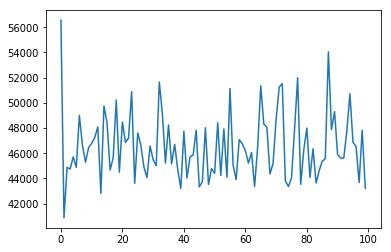

In [20]:
plt.plot(evaluation5)

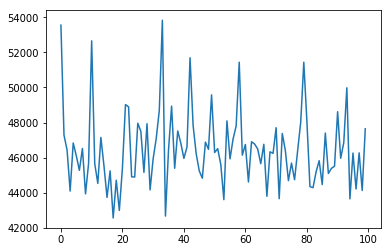

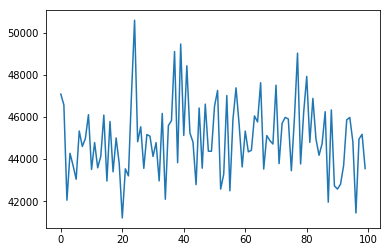

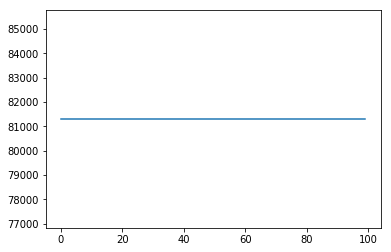

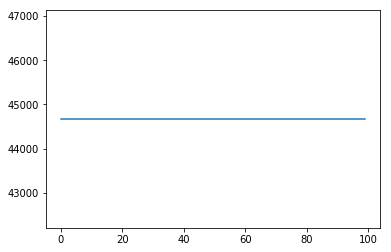

In [18]:
plt.plot(evaluation1)
plt.show()
plt.plot(evaluation2)
plt.show()
plt.plot(evaluation3)
plt.show()
plt.plot(evaluation4)
plt.show()

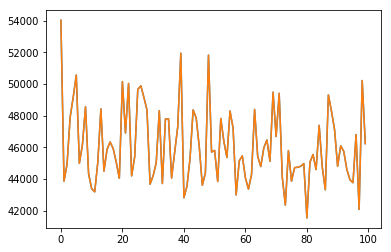

In [16]:
plt.plot(range(100), evaluation, evaluation)

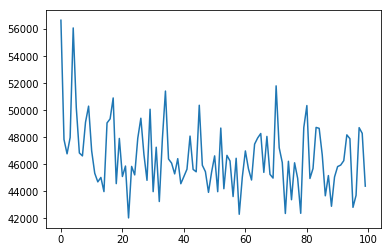

In [33]:
plt.plot(evaluation)

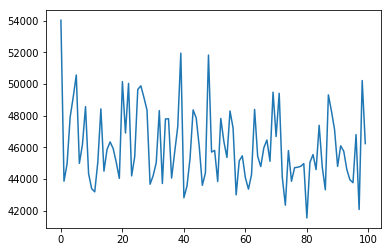

In [9]:
plt.plot(evaluation)

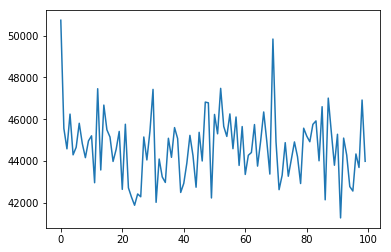

In [4]:
plt.plot(evaluation)

 Retrying in 1 seconds
4175
 Retrying in 1 seconds
4175
 Retrying in 1 seconds
4175
 Retrying in 1 seconds
4175
 Retrying in 1 seconds
4175
 Retrying in 1 seconds
4175
 Retrying in 1 seconds
4175
 Retrying in 1 seconds
4175
 Retrying in 1 seconds
4175
 Retrying in 1 seconds
4175


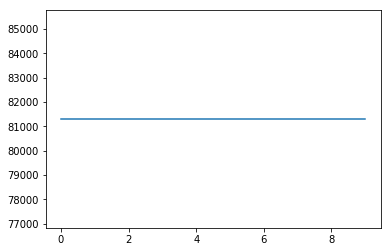

In [3]:
plt.plot(evaluation)

 Retrying in 1 seconds
0 [0, 0]
0 [0, 0]
1 [2, 0]
0 [0, 3]
1 [5, 0]
0 [0, 6]
1 [5, 0]
0 [0, 8]
1 [11, 0]
0 [0, 10]
1 [11, 0]
0 [0, 8]
1 [8, 0]
0 [0, 8]
1 [13, 0]
0 [0, 12]
1 [12, 0]
0 [0, 6]
1 [10, 0]
0 [0, 5]
1 [11, 0]
0 [0, 8]
1 [8, 0]
0 [1, 4]
1 [14, 0]
0 [0, 9]
1 [17, 0]
0 [1, 12]
1 [18, 0]
0 [1, 11]
1 [14, 0]
0 [0, 12]
1 [10, 0]
0 [4, 4]
1 [18, 0]
0 [1, 12]
1 [18, 3]
0 [1, 8]
1 [19, 0]
0 [1, 6]
1 [16, 0]
0 [0, 13]
1 [15, 0]
0 [3, 8]
1 [15, 0]
0 [0, 5]
1 [15, 0]
0 [0, 8]
1 [10, 1]
0 [2, 7]
1 [5, 0]
0 [0, 7]
1 [12, 0]
0 [0, 14]
1 [11, 1]
0 [0, 5]
1 [12, 0]
0 [3, 6]
1 [10, 0]
0 [1, 3]
1 [11, 0]
0 [5, 6]
1 [14, 0]
0 [4, 10]
1 [14, 0]
0 [1, 12]
1 [15, 1]
0 [0, 14]
1 [10, 0]
0 [0, 14]
1 [9, 0]
0 [0, 11]
1 [6, 1]
0 [1, 8]
1 [14, 0]
0 [4, 7]
1 [15, 0]
0 [0, 15]
1 [12, 3]
0 [0, 12]
1 [16, 1]
0 [2, 11]
1 [20, 0]
0 [6, 8]
1 [21, 0]
0 [4, 11]
1 [17, 0]
0 [3, 13]
1 [16, 3]
0 [4, 8]
1 [10, 0]
0 [3, 10]
1 [9, 0]
0 [1, 6]
1 [15, 0]
0 [1, 6]
1 [21, 0]
0 [2, 10]
1 [12, 0]
0 [0, 10]
1 [12, 0]
0 [1, 

1 [10, 0]
0 [0, 5]
1 [11, 0]
0 [0, 8]
1 [8, 0]
0 [1, 4]
1 [14, 0]
0 [0, 9]
1 [17, 0]
0 [1, 12]
1 [18, 0]
0 [1, 11]
1 [14, 0]
0 [0, 12]
1 [10, 0]
0 [4, 4]
1 [18, 0]
0 [1, 12]
1 [18, 3]
0 [1, 8]
1 [19, 0]
0 [1, 6]
1 [16, 0]
0 [0, 13]
1 [15, 0]
0 [3, 8]
1 [15, 0]
0 [0, 5]
1 [15, 0]
0 [0, 8]
1 [10, 1]
0 [2, 7]
1 [5, 0]
0 [0, 7]
1 [12, 0]
0 [0, 14]
1 [11, 1]
0 [0, 5]
1 [12, 0]
0 [3, 6]
1 [10, 0]
0 [1, 3]
1 [11, 0]
0 [5, 6]
1 [14, 0]
0 [4, 10]
1 [14, 0]
0 [1, 12]
1 [15, 1]
0 [0, 14]
1 [10, 0]
0 [0, 14]
1 [9, 0]
0 [0, 11]
1 [6, 1]
0 [1, 8]
1 [14, 0]
0 [4, 7]
1 [15, 0]
0 [0, 15]
1 [12, 3]
0 [0, 12]
1 [16, 1]
0 [2, 11]
1 [20, 0]
0 [6, 8]
1 [21, 0]
0 [4, 11]
1 [17, 0]
0 [3, 13]
1 [16, 3]
0 [4, 8]
1 [10, 0]
0 [3, 10]
1 [9, 0]
0 [1, 6]
1 [15, 0]
0 [1, 6]
1 [21, 0]
0 [2, 10]
1 [12, 0]
0 [0, 10]
1 [12, 0]
0 [1, 16]
1 [16, 0]
0 [1, 8]
1 [9, 0]
0 [1, 12]
1 [16, 0]
0 [1, 14]
1 [20, 1]
0 [0, 15]
1 [14, 1]
0 [2, 11]
1 [18, 0]
0 [0, 7]
1 [14, 0]
0 [2, 16]
1 [14, 2]
0 [2, 5]
1 [13, 0]
0 [3, 14]
1 [14, 0]
0

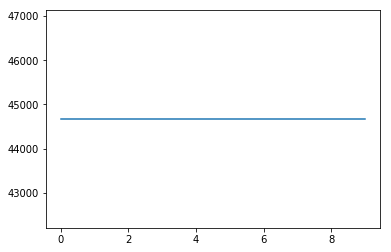

In [27]:
plt.plot(evaluation)

In [ ]:
# evaluateUnit = simulateAgent.train(20)
traci = TraciBackend()
traci.start()
for i in range(100):
    traci.simulate_step()
    print(traci.get_halt_vehicle_cnt_edge('1si'), 
          traci.get_halt_vehicle_cnt_edge('2si'), 
          traci.get_halt_vehicle_cnt_edge('3si'),
          traci.get_halt_vehicle_cnt_edge('4si'),
          traci.get_vehicle_cnt_edge('1si'), 
          traci.get_vehicle_cnt_edge('2si'), 
          traci.get_vehicle_cnt_edge('3si'),
          traci.get_vehicle_cnt_edge('4si'),
          traci.get_halt_vehicle_cnt('1si_1'), 
          traci.get_halt_vehicle_cnt('2si_1'), 
          traci.get_halt_vehicle_cnt('3si_1'),
          traci.get_halt_vehicle_cnt('4si_1'),
          traci.get_vehicle_cnt('1si_1'), 
          traci.get_vehicle_cnt('2si_1'), 
          traci.get_vehicle_cnt('3si_1'),
          traci.get_vehicle_cnt('4si_1'),
         )
traci.close()

In [ ]:
simulateAgent = LongestQueueFirstAgent()
evaluation = []
for _ in range(10):
    evaluateUnit = simulateAgent.train(20)
    evaluation.append(evaluateUnit)
plt.plot(evaluation)

In [ ]:
simulateAgent = Agent(0.9, 0.001, 0.05)
simulateAgent.train(20)
print(simulateAgent.weights1, simulateAgent.weights2)

In [ ]:
if __name__ == '__main__':
    simulateAgent = Agent(0.5, 0.0001, 0.05)
    for _ in range(10):
        simulateAgent.train(20)
        print(simulateAgent.weights1, simulateAgent.weights2)

In [ ]:
traci = TraciBackend()
traci.start()
traci.close()